In [2]:
import json
import pandas as pd


In [3]:
with open("solutions_evo_NEW.json", "r") as f:
    data = json.load(f)
    # data = pd.DataFrame(data

X = {problem: [] for problem in data}
y = {problem: [] for problem in data}

for problem, problem_results in data.items():
    for result in problem_results:
        for x, cost in zip(result["X"], result["y"]):
            X[problem].append(x)
            y[problem].append(cost)
    X[problem] = pd.Series(X[problem])
    y[problem] = pd.Series(y[problem])


In [86]:
TSPA_X = pd.Series(X["TSPA"])
TSPA_y = pd.Series(y["TSPA"])
TSPA_X.describe()


count                                                 36325
unique                                                22438
top       [177, 75, 189, 109, 119, 134, 99, 101, 167, 17...
freq                                                    143
dtype: object

In [87]:
TSPA_y.describe()

count    36325.000000
mean     74155.719862
std        929.807696
min      72905.000000
25%      73500.000000
50%      73819.000000
75%      74531.000000
max      80653.000000
dtype: float64

In [88]:
most_common = TSPA_X.value_counts().idxmax()
values = []
for i, obj in enumerate(TSPA_X):
    if obj == most_common:
        values.append(TSPA_y[i])

print(set(values))


{76141.0}


We can drop all the same values from X

In [89]:
for problem in X:
    # drop all duplicates from X and corresponding y
    X[problem] = X[problem].drop_duplicates()
    y[problem] = y[problem].loc[X[problem].index]

In [90]:
for problem in y:
    mean = y[problem].mean()
    y[problem][y[problem] <= mean] = 1
    y[problem][y[problem] > mean] = 0
    print(y[problem].describe())


count    22438.000000
mean         0.639050
std          0.480287
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64
count    23214.000000
mean         0.652968
std          0.476036
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64
count    23582.000000
mean         0.673225
std          0.469044
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64
count    24206.000000
mean         0.666612
std          0.471434
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64


In [91]:
# train classifier for each problem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# import random forest and other classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


classifiers = {}

for problem in X:
    X_array = X[problem].apply(pd.Series).values

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X_array, y[problem], test_size=0.2, random_state=42
    # )
    n = len(X_array)
    X_train, X_test, y_train, y_test = (
        X_array[: int(n * 0.8)],
        X_array[int(n * 0.8) + 1 :],
        y[problem][: int(n * 0.8)],
        y[problem][int(n * 0.8) + 1 :],
    )
    best_Acc = 0
    print(f"\n\nTraining {problem} classifier")
    for clf in [SVC, RandomForestClassifier, AdaBoostClassifier, MLPClassifier]:
        clf_name = clf.__name__
        clf = clf()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{clf_name} accuracy: {acc}")
        if acc > best_Acc:
            best_Acc = acc
            classifiers[problem] = clf




Training TSPA classifier
SVC accuracy: 0.7693336304880767
RandomForestClassifier accuracy: 0.7851571205705371
AdaBoostClassifier accuracy: 0.7321149988856697
MLPClassifier accuracy: 0.7147314464007132


Training TSPB classifier
SVC accuracy: 0.7675570874623008
RandomForestClassifier accuracy: 0.7781128823782852
AdaBoostClassifier accuracy: 0.7279190004308488
MLPClassifier accuracy: 0.7339508832399828


Training TSPC classifier
SVC accuracy: 0.832273112807464
RandomForestClassifier accuracy: 0.8379983036471587
AdaBoostClassifier accuracy: 0.792832909245123
MLPClassifier accuracy: 0.6694232400339271


Training TSPD classifier
SVC accuracy: 0.7469531088618054
RandomForestClassifier accuracy: 0.7436480066102045
AdaBoostClassifier accuracy: 0.6996488328857674
MLPClassifier accuracy: 0.5432761826068994


Grid search for randomforest - unfrtunately no time for it

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

for problem in X:
    X_array = X[problem].apply(pd.Series).values

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X_array, y[problem], test_size=0.2, random_state=42
    # )
    n = len(X_array)
    X_train, X_test, y_train, y_test = (
        X_array[: int(n * 0.8)],
        X_array[int(n * 0.8) + 1:],
        y[problem][: int(n * 0.8)],
        y[problem][int(n * 0.8) + 1:],
    )
    best_Acc = 0
    print(f"\n\nTraining {problem} classifier")

    rf = RandomForestClassifier()
    random_grid = {
        "n_estimators": [100, 150, 200, 250],
        "max_depth": [None, 10, 20, 40, 60, 100],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    }

    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=random_grid,
        n_iter=10,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )

    rf_random.fit(X_train, y_train)

    print(rf_random.best_params_)
    print(rf_random.best_score_)
    classifiers[problem] = rf_random.best_estimator_



Training TSPA classifier
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [80]:
classifiers_small = {problem: {i: 0 for i in range(50, 2300, 50)} for problem in X}

for problem in X:
    X_array = X[problem].apply(pd.Series).values

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X_array, y[problem], test_size=0.2, random_state=42
    # )
    n = len(X_array)
    X_train, X_test, y_train, y_test = (
        X_array[: int(n * 0.8)],
        X_array[int(n * 0.8) + 1 :],
        y[problem][: int(n * 0.8)],
        y[problem][int(n * 0.8) + 1 :],
    )
    print(f"\n\nTraining {problem} classifier")
    for i in range(50, n, 50):
        X_train_small = X_train[:i]
        y_train_small = y_train[:i]
        for clf in [RandomForestClassifier]:
            clf_name = clf.__name__
            clf = clf()
            clf.fit(X_train_small, y_train_small)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            classifiers_small[problem][i] = acc
            print(f"{i}: {acc}")




Training TSPA classifier
50: 0.45401174168297453
100: 0.3659491193737769
150: 0.4344422700587084
200: 0.4207436399217221
250: 0.41682974559686886
300: 0.4657534246575342
350: 0.5675146771037182
400: 0.6829745596868885
450: 0.6340508806262231
500: 0.7377690802348337
550: 0.7906066536203522
600: 0.7514677103718199
650: 0.7338551859099804
700: 0.7729941291585127
750: 0.7495107632093934
800: 0.7553816046966731
850: 0.7808219178082192
900: 0.7455968688845401
950: 0.7925636007827789
1000: 0.7729941291585127
1050: 0.7475538160469667
1100: 0.6614481409001957
1150: 0.7025440313111546
1200: 0.7377690802348337
1250: 0.7142857142857143
1300: 0.7671232876712328
1350: 0.786692759295499
1400: 0.7671232876712328
1450: 0.7808219178082192
1500: 0.7318982387475538
1550: 0.7514677103718199
1600: 0.776908023483366
1650: 0.7710371819960861
1700: 0.7397260273972602
1750: 0.7299412915851272
1800: 0.7181996086105675
1850: 0.7573385518590998
1900: 0.7299412915851272
1950: 0.7318982387475538
2000: 0.7906066536

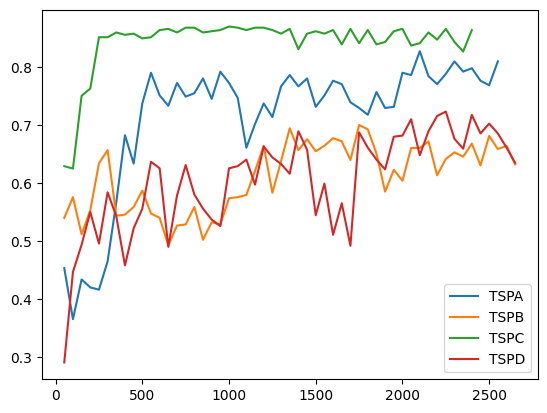

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

for problem in classifiers_small:
    plt.plot(
        classifiers_small[problem].keys(),
        classifiers_small[problem].values(),
        label=problem,
    )
    plt.legend()


In [92]:
# save classifiers
import pickle
import os

for problem in classifiers:
    # ensure existence of classifiers folder
    try:
        os.mkdir("classifiers")
    except FileExistsError:
        pass
    with open(f"classifiers/{problem}_big.pkl", "wb") as f:
        pickle.dump(classifiers[problem], f)


In [93]:
# open classifiers and predict on X and y
for problem in classifiers:
    with open(f"classifiers/{problem}_big.pkl", "rb") as f:
        clf = pickle.load(f)
        y_pred = clf.predict(X[problem].apply(pd.Series).values)
        print(f"{problem}: {accuracy_score(y[problem], y_pred)}")


TSPA: 0.9569926018361707
TSPB: 0.9556302231412079
TSPC: 0.9676024086167416
TSPD: 0.909526563661902


In [100]:
import random

random_100 = [random.randint(0, 1) for _ in range(100)]
with open(f"classifiers/TSPA_big.pkl", "rb") as f:
    clf = pickle.load(f)
    y_pred = clf.predict([random_100])
    print(y_pred)

[1.]


In [5]:
for problem in y:
    print(y[problem].mean())


74155.71986235376
67488.92591495435
48630.734787472036
45073.078555863445
